# Distinguishing between sarcastic and regular news headlines with text classification methods


Sarcasm or irony are characteristics of language particularly difficult for machine to recognize. One can define sarcasm as the use of words that mean the opposite of what you really want to say. In order to understand if something is being said sarcastically you need to take into consideration the whole context of the situation, which is largely outside of the analyzed statement itself. Which is something that machine learning algorythm cannot do.

However in practice, usually there can be found some traits within used language itself that indicate intention behind statement. The goal of this project (beside beeing bootcamp's final project) is to see to what extend ML algorythms can handle recognizing sarcasm in news headlines.

Dataset used for that and its description can be found here: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


In [1]:
import numpy as np
import re
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# tokenization
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
# nltk.download('stopwords')

from wordcloud import WordCloud
from collections import Counter

# features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost.sklearn import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from joblib import dump, load
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set()

## Loading the data

In [3]:
df = pd.read_json('Data/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [4]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
# Lets leave only columns we need.

df = df[['headline', 'is_sarcastic']]

## Cleaning

Data has been largely cleaned for us and not much is left to do in that regard. Also, because news headlines are written by professionals in highly formalized manner, we can expect that there won't be much spelling mistakes or other noise of that kind. But! To be sure we perform some basic cleanig on our own.

In [6]:
# checking for nulls

df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [7]:
# cleaning non alphanumeric characters and capital letters

def cleaner(txt):
    tokenizer = RegexpTokenizer('\w+')
    return ' '.join(tokenizer.tokenize(txt.lower()))

df['headline'] = df['headline'].map(cleaner)

- Stemization or lemmatization could deprive us of potentially valuable information, because unconventional use of words can be one of the indicators that something is being said humoristicly, so decision has been made to not use niether of those methods.


- We keep stop words for now, because they can potentially turn out to be usefull.


- The rest can be managed through parameters of vectorizers.

## EDA

In [8]:
# size of dataset
len(df)

28619

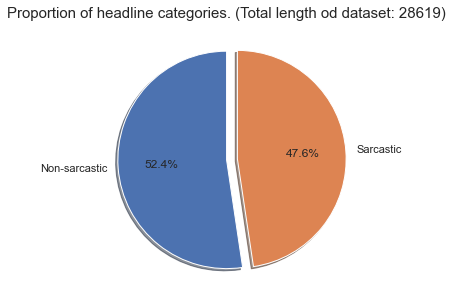

In [9]:
# proportion of categories in dataset

labels = ['Non-sarcastic', 'Sarcastic']
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.pie(df.is_sarcastic.value_counts(),
        explode = explode,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        shadow=True)
ax.set_title(f'Proportion of headline categories. (Total length od dataset: {len(df)})', fontsize=15)
plt.show()

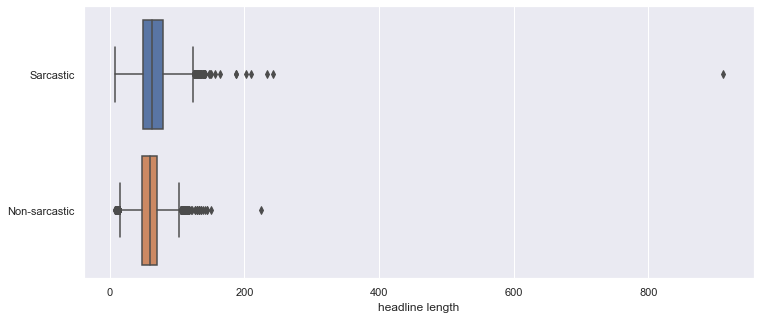

In [10]:
# length of headlines in characters

plt.figure(figsize=(12, 5))
sns.boxplot(y=np.where(df.is_sarcastic==0, 'Non-sarcastic', 'Sarcastic'), x=df.headline.str.len())
plt.xlabel('headline length');

In [11]:
# getting rid of the outlier

df.drop(index=df[df.headline.str.len()>400].index, inplace=True)

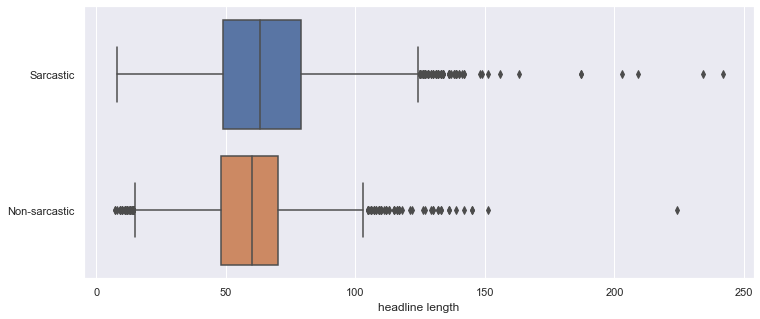

In [12]:
plt.figure(figsize=(12, 5))
sns.boxplot(y=np.where(df.is_sarcastic==0, 'Non-sarcastic', 'Sarcastic'), x=df.headline.str.len())
plt.xlabel('headline length');

Generally we can see that data is relatively well balanced and headlines have similiar length across the categories. Sarcastic category varies a little bit more and has slightly more long headlines, which is understandable because creating Onion headline is not restricted as much as profesional ones. But it shouldn't affect us.

In [13]:
# function returning counts of most frequent words

def top_words(column, top_n):
    tokenizer = RegexpTokenizer('\w{2,}')
    words = tokenizer.tokenize(' '.join(column))
    words = [w for w in words if w not in stopwords.words('english')]
    return dict(Counter(words).most_common(top_n))

non_sarc_words = top_words(df[df.is_sarcastic == 0].headline, 500)
sarc_words = top_words(df[df.is_sarcastic == 1].headline, 500)


# getting dicts of counts of top words specific for a category

non_sarc_specific = {w: c for w, c in non_sarc_words.items() if w not in sarc_words}
sarc_specific = {w: c for w, c in sarc_words.items() if w not in non_sarc_words}

In [14]:
# function for word clouds

def clouds(counts1, counts2, category_name):
    wc1 = WordCloud(background_color='white', width = 1600, height = 1400,  max_words=100)
    wc1.generate_from_frequencies(counts1)
    
    wc2 = WordCloud(background_color='white', width = 1600, height = 1400, max_words=100)
    wc2.generate_from_frequencies(counts2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    ax1.imshow(wc1)
    ax1.axis('off')
    ax1.set_title('Most frequent words', fontsize=16)

    ax2.imshow(wc2)
    ax2.axis('off')
    ax2.set_title(f'Words specific for category', fontsize=16)
    
    fig.suptitle(f'{category_name} headlines', fontsize = 18)

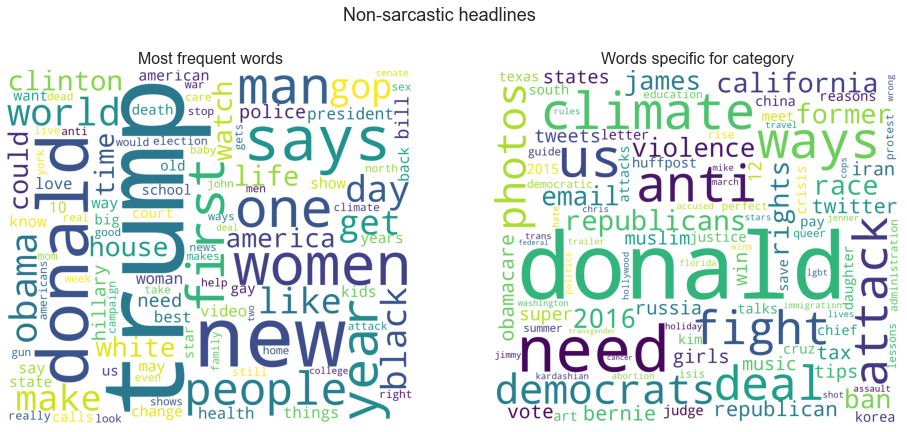

In [15]:
clouds(non_sarc_words, non_sarc_specific, 'Non-sarcastic')

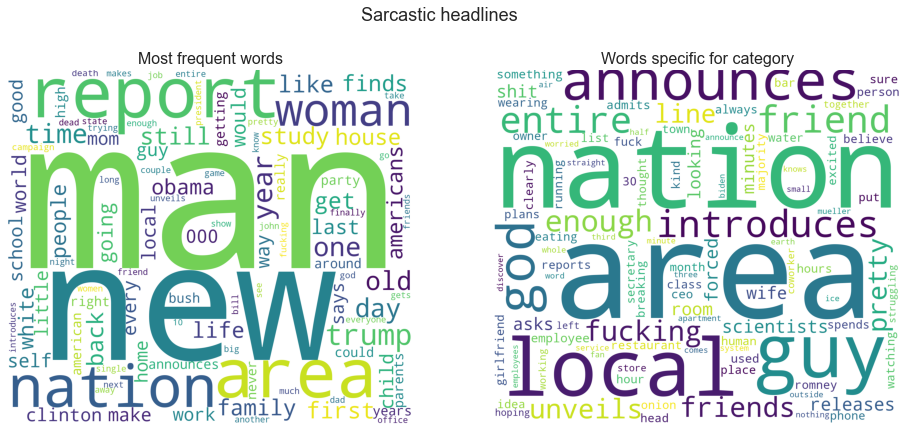

In [16]:
clouds(sarc_words, sarc_specific, 'Sarcastic')

In [17]:
from scipy.sparse import csr_matrix

# function to get most frequent ngrams and their counts

def top_ngrams(column, ngram_range=(2,2), n=20):

    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    matrix = vectorizer.fit_transform(column)
    sums = np.squeeze(np.asarray(csr_matrix(matrix).sum(axis=0)))
    top_indices = np.argsort(sums)[:-(n+1):-1]
    top_ngrams = np.array(vectorizer.get_feature_names())[top_indices]
    counts = sums[top_indices]
    
    return top_ngrams, counts


# function to make a barchart of most frequent ngrams in sarcastic and non sarcastic headlines

def top_ngram_chart(top_ns_ngrams, top_s_ngrams):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 12))
    fig.suptitle('Most frequent ngrams in headlines', fontsize=16)
    sns.barplot(ax=ax1, x=top_ns_ngrams[1], y=top_ns_ngrams[0], palette='flare')
    ax1.set_title('Non-sarcastic', fontsize=14)

   
    sns.barplot(ax=ax2, x=top_s_ngrams[1], y=top_s_ngrams[0], palette='flare')
    ax2.set_title('Sarcastic', fontsize=14)

    max_value = max(top_s_ngrams[1].max(), top_ns_ngrams[1].max())
    ax1.set_xlim(right=max_value + 0.1*max_value)
    ax2.set_xlim(right=max_value + 0.1*max_value)
    ;

top_s_bigrams = top_ngrams(df.headline[df.is_sarcastic==1], n=30)
top_ns_bigrams = top_ngrams(df.headline[df.is_sarcastic==0], n=30)

top_s_trigrams = top_ngrams(df.headline[df.is_sarcastic==1], ngram_range=(3,3), n=30)
top_ns_trigrams = top_ngrams(df.headline[df.is_sarcastic==0], ngram_range=(3,3), n=30)

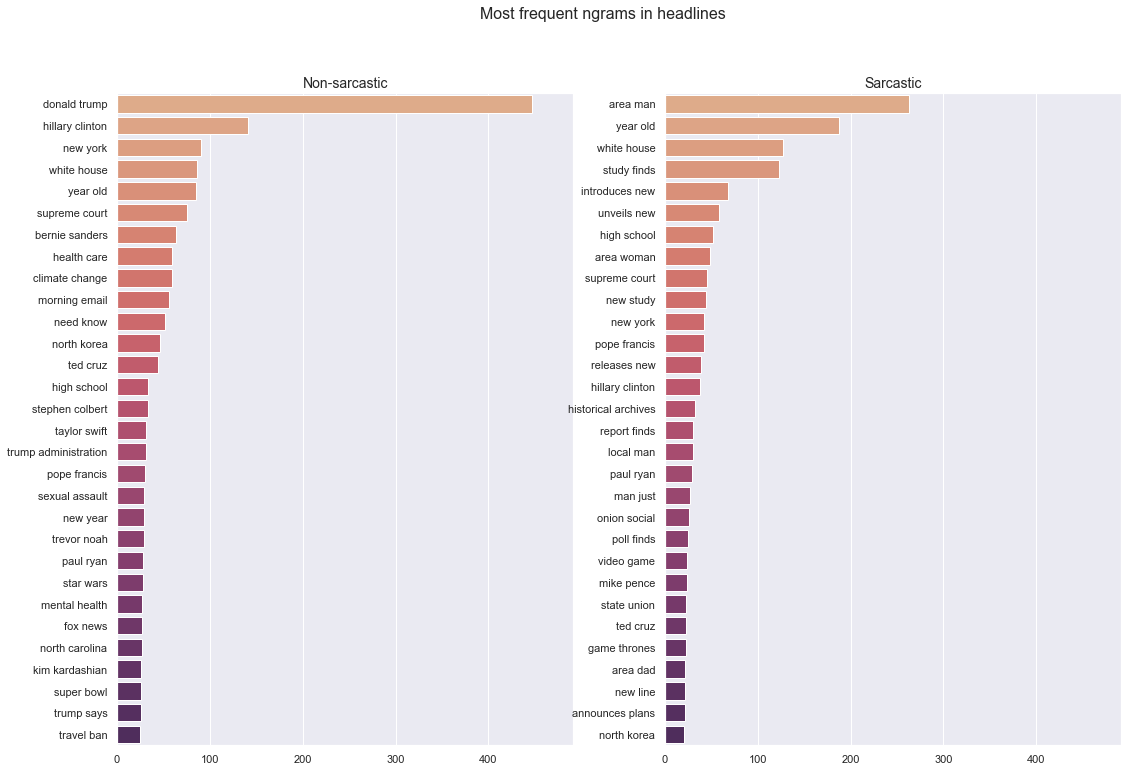

In [20]:
top_ngram_chart(top_ns_bigrams, top_s_bigrams)

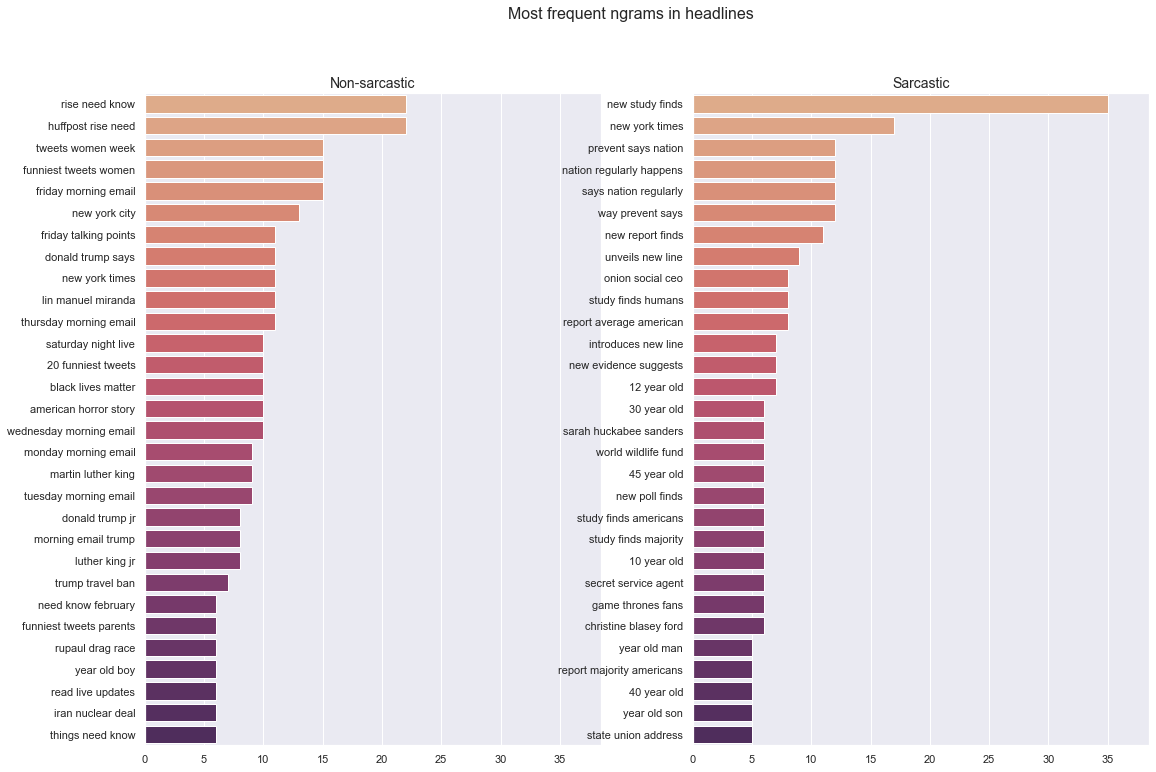

In [19]:
top_ngram_chart(top_ns_trigrams, top_s_trigrams)

From the glance at most common words and ngrams we can see that normal headlines more often mention names of specific people, places or organisations and refer to current events while sarcastic ones tend to use words with more general meaning.

## Train and test datasets

In [21]:
# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(df.headline, df.is_sarcastic,
                                                    test_size=0.3, stratify=df.is_sarcastic,
                                                    random_state=10)

## Feature extraction

### Text Vectorization

We want to choose type and parameters of vectorizer before training models, so we dont have to do it every time we run a grid search tuning their hyperparameters. This might be suboptimal from the point of maximizing the accuracy, but it saves a lot of calculation time. We test vectorizers on three models with default settings. 

In [22]:
# 3 simple models for testing vectorizers
simple_models = [MultinomialNB(), LogisticRegression(), DecisionTreeClassifier(max_depth=20)]
# max depth of the Decision Tree is restricted to save calculation time

count_vec_scores=[]
tfidf_vec_scores=[]

for model in simple_models:
    count_pipe = make_pipeline(CountVectorizer(), model)
    tfidf_pipe = make_pipeline(TfidfVectorizer(), model)
    
    count_vec_scores.append(cross_val_score(count_pipe, X_train, y_train, cv=10).mean().round(3))
    tfidf_vec_scores.append(cross_val_score(tfidf_pipe, X_train, y_train, cv=10).mean().round(3))

pd.DataFrame({'Model':simple_models, 'Counter score': count_vec_scores, 'Tfidf score': tfidf_vec_scores})

,Model,Counter score,Tfidf score
0,MultinomialNB(),0.846,0.832
1,LogisticRegression(),0.840,0.840
2,DecisionTreeClassifier(max_depth=20),0.718,0.724


Scores of Counter and Tfidf vectorizers are almost identical. Because during some rough testing Tfidf seemed to perform a little bit better, for convinience we stick to it.

In [23]:
# choosing best parameters for vectorizer
best_params = []
for model in simple_models:
    pipe = make_pipeline(TfidfVectorizer(), model)
    cv_model = GridSearchCV(pipe,
                           param_grid={'tfidfvectorizer__ngram_range':[(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
                                      'tfidfvectorizer__stop_words':[None, 'english'],
                                      'tfidfvectorizer__token_pattern': ['(?u)\\b\\w\\w+\\b', '(?u)\\b\\w+\\b'],
                                      'tfidfvectorizer__min_df': [1, 2],
                                      'tfidfvectorizer__max_df': [0.9, 1.0]},
                           cv=4,
                           n_jobs=-1)
    cv_model.fit(X_train, y_train)
    best_params.append(cv_model.best_params_)

pd.DataFrame(best_params, index=simple_models)

,tfidfvectorizer__max_df,tfidfvectorizer__min_df,tfidfvectorizer__ngram_range,tfidfvectorizer__stop_words,tfidfvectorizer__token_pattern
MultinomialNB(),0.9,2,"(1, 3)",None,(?u)\b\w+\b
LogisticRegression(),0.9,2,"(1, 2)",None,(?u)\b\w+\b
DecisionTreeClassifier(max_depth=20),1.0,2,"(1, 1)",None,(?u)\b\w+\b


- Tokenizer that includes one letter words works better for every model.


- The same can be said about including stop words.


- min df should be set on 2, and max df on 0.9.


- Using only unigrams works best for very shallow tree, but we can expect that in most of other cases it won't be best choice. We still have to decide weather we keep trigrams or not.

In [24]:
# comparing 1-2 and 1-3 ngram ranges
accuracies = []
feature_count = []
for model in simple_models:
    for ngram_range in [(1,2),(1,3)]:
        pipe = make_pipeline(TfidfVectorizer(ngram_range=ngram_range, stop_words=None,
                                             token_pattern='(?u)\\b\\w+\\b',
                                             min_df=2,
                                             max_df=0.9),
                             model)
        pipe.fit(X_train, y_train)
        accuracies.append(cross_val_score(pipe, X_train, y_train, cv=4, n_jobs=-1).mean())
        feature_count.append(len(pipe[0].get_feature_names()))
pd.DataFrame({'Accuracy score': accuracies, 'Number of features': feature_count},
             index=[['MultinomialNB', 'MultinomialNB', 'LogisticRegression', 'LogisticRegression', 'DecisionTreeClassifier(max_depth=20)', 'DecisionTreeClassifier(max_depth=20)'],
                    [(1, 2), (1, 3), (1, 2), (1, 3), (1, 2), (1, 3)]])

Accuracy score  \
MultinomialNB                        (1, 2)        0.846845   
                                     (1, 3)        0.848542   
LogisticRegression                   (1, 2)        0.847993   
                                     (1, 3)        0.847993   
DecisionTreeClassifier(max_depth=20) (1, 2)        0.737071   
                                     (1, 3)        0.736671   

                                             Number of features  
MultinomialNB                        (1, 2)               31753  
                                     (1, 3)               37918  
LogisticRegression                   (1, 2)               31753  
                                     (1, 3)               37918  
DecisionTreeClassifier(max_depth=20) (1, 2)               31753  
                                     (1, 3)               37918

As we can see, difference between 1-2 and 1-3 ngram ranges are minimal but adding trigrams adds 6k more features, so we decide to go with 1-2 ngram range.

### Feature Selection

Similiarly, we choose the number of features before we search for the best model, to save some calculation time in next steps.

In [25]:
# choosing best number of features
simple_models = [MultinomialNB(), LogisticRegression(), DecisionTreeClassifier()]

best_params = []
for model in simple_models:
    pipe = make_pipeline(TfidfVectorizer(ngram_range = (1,2), stop_words=None,
                                         token_pattern='(?u)\\b\\w+\\b',
                                         min_df = 2,
                                         max_df=0.9),
                         SelectKBest(chi2), model)
    cv_model = GridSearchCV(pipe,
                           param_grid={'selectkbest__k': np.arange(15000, 31000, 1000)},
                           cv=4,
                           n_jobs=-1)
    cv_model.fit(X_train, y_train)
    best_params.append(cv_model.best_params_)

pd.DataFrame(best_params, index=simple_models)

,selectkbest__k
MultinomialNB(),20000
LogisticRegression(),21000
DecisionTreeClassifier(),16000


Best number of features vary between different models. For three simple models we tried out it's between 16k and 21k. The decision has been made to go with 22k, because potential negative effect of having too many variables can be mitigated by tuning regularization parameters and other models can benefit from extra information.

## Fitting models

Because dataset is relatively well balanced we can use accuracy as the metric for model evaluation. As a baseline we can consider 50% accuracy we would achieve with just random guessing.

In [39]:
# function adding model to pipeline with feature extraction and searching for best estimator

def grid_search(model, model_name, param_grid):
    pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range = (1,2), stop_words=None,
                                                    token_pattern='(?u)\\b\\w+\\b',
                                                    min_df=2,
                                                    max_df=0.9)),
                    ('selector', SelectKBest(chi2, k=22000)),
                    (model_name, model)])
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print('Best parameters: ', gs.best_params_)
    print('Best score: ', gs.best_score_)
    
    return gs.best_estimator_


In [40]:
# function evaluating estimator on test set

def evaluate(model):
    print('Accuracy on training set: ', accuracy_score(y_train, model.predict(X_train)))
    print('Accuracy on testing set: ', accuracy_score(y_test, model.predict(X_test)))
    print()
    print(classification_report(y_test, model.predict(X_test)))

In [41]:
best_models = []

### Naive Bayes Classificator


In [42]:
param_grid = {'MultinomialNB__alpha': [0.01, 0.1, 0.5, 1, 2, 5]}
naive_beyes = grid_search(MultinomialNB(), 'MultinomialNB', param_grid)

Best parameters:  {'MultinomialNB__alpha': 1}
Best score:  0.8516370938974618


In [43]:
evaluate(naive_beyes)

Accuracy on traing dataset:  0.9441892971246006
Accuracy on testing dataset:  0.852317726531563

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4496
           1       0.87      0.81      0.84      4090

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586



In [44]:
best_models.append(naive_beyes)

In [45]:
dump(naive_beyes, 'Models\MultinomialNB.pkl')

['Models\\MultinomialNB.pkl']

### Logistic Regression

In [48]:
param_grid = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 20],
             'lr__penalty': ['l1', 'l2']}

log_reg = grid_search(LogisticRegression(solver='saga'), 'lr', param_grid)

Best parameters:  {'lr__C': 5, 'lr__penalty': 'l2'}
Best score:  0.8585760366188924


In [49]:
# additional search for best C parameter around 5

param_grid = {'lr__C': np.arange(3, 9, 1)}
log_reg_l2 = grid_search(LogisticRegression('l2'), 'lr', param_grid)

Best parameters:  {'lr__C': 5}
Best score:  0.858326411057235


In [50]:
evaluate(log_reg)

Accuracy on traing dataset:  0.9650059904153354
Accuracy on testing dataset:  0.8610528767761472

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4496
           1       0.85      0.86      0.85      4090

    accuracy                           0.86      8586
   macro avg       0.86      0.86      0.86      8586
weighted avg       0.86      0.86      0.86      8586



In [52]:
best_models.append(log_reg)

In [53]:
dump(log_reg, 'Models\LogisticRegression.pkl')

['Models\\LogisticRegression.pkl']

### Decision Tree

In [54]:
param_grid = {'dt__max_depth': [100, 200, 300, 400],
             'dt__min_samples_leaf': [None, 2, 5, 10]}

dec_tree = grid_search(DecisionTreeClassifier(), 'dt', param_grid)

Best parameters:  {'dt__max_depth': 100, 'dt__min_samples_leaf': 10}
Best score:  0.7341254153209916


In [55]:
# additional search

param_grid = {'dt__max_depth': np.arange(60, 160, 20),
             'dt__min_samples_leaf': [None, 3, 5, 8, 10, 12, 15]}

dec_tree = grid_search(DecisionTreeClassifier(), 'dt', param_grid)

Best parameters:  {'dt__max_depth': 60, 'dt__min_samples_leaf': 10}
Best score:  0.7381186642795975


In [56]:
# we keep searching because we got lowest value from the range, but admittedly differences are so small
# it may be just effect of sampling

param_grid = {'dt__max_depth': np.arange(40, 80, 10),
              'dt__min_samples_leaf': [8, 10, 12]}

dec_tree = grid_search(DecisionTreeClassifier(), 'dt', param_grid)

Best parameters:  {'dt__max_depth': 40, 'dt__min_samples_leaf': 10}
Best score:  0.7411639964560273


In [58]:
# and again

param_grid = {'dt__max_depth': np.arange(30, 50, 5),
              'dt__min_samples_leaf': [8, 10, 12]}

dec_tree = grid_search(DecisionTreeClassifier(), 'dt', param_grid)

Best parameters:  {'dt__max_depth': 45, 'dt__min_samples_leaf': 10}
Best score:  0.7416133473859587


In [59]:
evaluate(dec_tree)

Accuracy on traing dataset:  0.7962759584664537
Accuracy on testing dataset:  0.7410901467505241

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      4496
           1       0.72      0.75      0.73      4090

    accuracy                           0.74      8586
   macro avg       0.74      0.74      0.74      8586
weighted avg       0.74      0.74      0.74      8586



In [60]:
best_models.append(dec_tree)

In [61]:
dump(dec_tree, 'Models\DecisionTreeClassifier.pkl')

['Models\\DecisionTreeClassifier.pkl']

### Random Forest

In [65]:
param_grid = {'rf__max_depth': [45, 100, 150, 180],
             'rf__min_samples_leaf': [None, 2, 3, 5, 10],
             'rf__n_estimators': [50, 100, 150, 250, 300]}

rand_forest = grid_search(RandomForestClassifier(), 'rf', param_grid)

Best parameters:  {'rf__max_depth': 180, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 300}
Best score:  0.8134486316444974


In [68]:
# additional search

param_grid = {'rf__max_depth': [None, 160, 180, 200],
             'rf__min_samples_leaf': [None, 2, 5],
             'rf__n_estimators': [300, 500, 1000]}

rand_forest = grid_search(RandomForestClassifier(), 'rf', param_grid)

Best parameters:  {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 1000}
Best score:  0.8157950620861818


In [70]:
# another search

param_grid = {'rf__n_estimators': [800, 1000, 1200]}

rand_forest = grid_search(RandomForestClassifier(max_depth=None, min_samples_leaf=2), 'rf', param_grid)

Best parameters:  {'rf__n_estimators': 1000}
Best score:  0.8147965722990259


In [71]:
evaluate(rand_forest)

Accuracy on traing dataset:  0.9047024760383386
Accuracy on testing dataset:  0.8145818774749592

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      4496
           1       0.82      0.78      0.80      4090

    accuracy                           0.81      8586
   macro avg       0.81      0.81      0.81      8586
weighted avg       0.81      0.81      0.81      8586



In [72]:
best_models.append(rand_forest)

In [73]:
dump(rand_forest, 'Models\RandomForestClassifier.pkl')

['Models\\RandomForestClassifier.pkl']

### SVM

In [74]:
param_grid = {'svm__kernel': ['linear', 'poly', 'rbf'],
             'svm__C': [0.1, 0.5, 1, 10, 50]}

svm = grid_search(SVC(), 'svm', param_grid)

Best parameters:  {'svm__C': 10, 'svm__kernel': 'rbf'}
Best score:  0.8592249384844619


In [77]:
# additional search

param_grid = {'svm__C': [5, 8, 10, 15]},
svm = grid_search(SVC(kernel='rbf'), 'svm', param_grid)

Best parameters:  {'svm__C': 10}
Best score:  0.8592249384844619


In [78]:
evaluate(svm)

Accuracy on traing dataset:  0.9995507188498403
Accuracy on testing dataset:  0.8541812252504076

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4496
           1       0.85      0.85      0.85      4090

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586



In [79]:
# in order to predict probability with that model we need verion of it with probability argument equel True
svm = grid_search(SVC(probability=True, C=10), 'svm', {})

Best parameters:  {}
Best score:  0.8592249384844619


In [80]:
best_models.append(svm)

In [81]:
dump(svm, 'Models\SVC.pkl')

['Models\\SVC.pkl']

### XGBoost

In [82]:
# First we optimize n_estimators and learning_rate, then max_depth and min_child_weight to save calculation time

In [83]:
param_grid = {'xgb__n_estimators': [20, 50, 100],
    'xgb__learning_rate': [0.3, 0.5, 0,7]}

xgb = grid_search(XGBClassifier(), 'xgb', param_grid)

Best parameters:  {'xgb__learning_rate': 0.5, 'xgb__n_estimators': 100}
Best score:  0.7979326617759909


In [84]:
# additional search
param_grid = {'xgb__n_estimators': [100, 250, 500],
    'xgb__learning_rate': [0.4, 0.5, 0,6]}

xgb = grid_search(XGBClassifier(), 'xgb', param_grid)

Best parameters:  {'xgb__learning_rate': 0.5, 'xgb__n_estimators': 500}
Best score:  0.8252373623243697


In [85]:
# n_estimators is still on the edge of the range, so we keep searching
param_grid = {'xgb__n_estimators': [500, 800, 1000]}

xgb = grid_search(XGBClassifier(learning_rate=0.5), 'xgb', param_grid)

Best parameters:  {'xgb__n_estimators': 800}
Best score:  0.8280329817228239


In [86]:
# now we optimize second batch of hyperparameters
param_grid = {"xgb__max_depth": [3, 5, 10],
              "xgb__min_child_weight": [1, 3, 5, 10, 15]}
xgb = grid_search(XGBClassifier(learning_rate=0.5, n_estimators=800), 'xgb', param_grid)

Best parameters:  {'xgb__max_depth': 5, 'xgb__min_child_weight': 1}
Best score:  0.8289314094742588


In [87]:
evaluate(xgb)

Accuracy on training set:  0.9665551839464883
Accuracy on testing set:  0.8276263685068717

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4496
           1       0.82      0.82      0.82      4090

    accuracy                           0.83      8586
   macro avg       0.83      0.83      0.83      8586
weighted avg       0.83      0.83      0.83      8586



In [88]:
best_models.append(xgb)

In [89]:
dump(xgb, 'Models\XGBClassifier.pkl')

['Models\\XGBClassifier.pkl']

## Comparing models

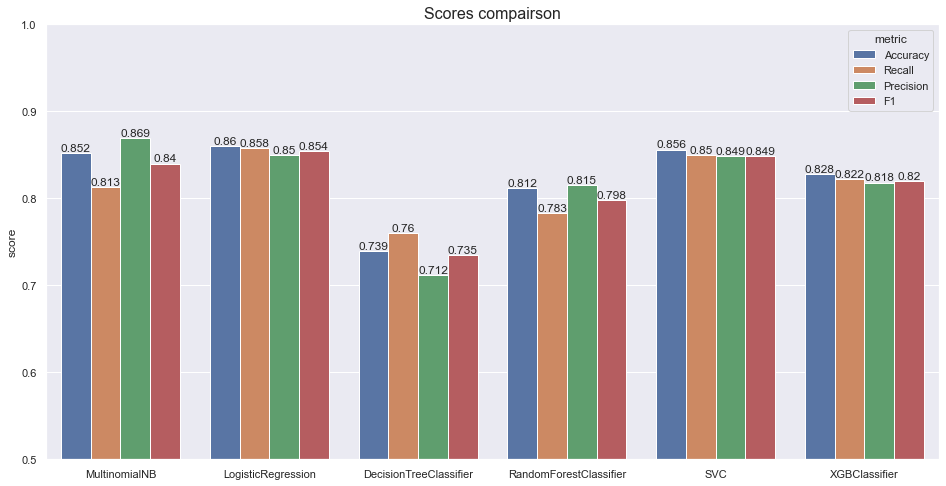

In [93]:
# table with scores of best models

accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in best_models]
recalls = [recall_score(y_test, model.predict(X_test)) for model in best_models]
precision = [precision_score(y_test, model.predict(X_test)) for model in best_models]
f1s = [f1_score(y_test, model.predict(X_test)) for model in best_models]

model_names = [model[-1].__class__.__name__ for model in best_models]

table = pd.DataFrame({'Accuracy': accuracies, 'Recall': recalls, 'Precision': precision, 'F1': f1s},
             index = model_names)

# barchart of these scores
table_melted = table.melt(var_name ="metric", value_name='score', ignore_index=False)
table_melted['score'] = table_melted['score'].round(3)

plt.figure(figsize=(16,8))
ax = sns.barplot(x=table_melted.index, y=table_melted.score, hue=table_melted.metric)
ax.set_ylim(0.5, 1)
ax.set_title('Scores compairson', fontsize=16)

for container in ax.containers:
    ax.bar_label(container)

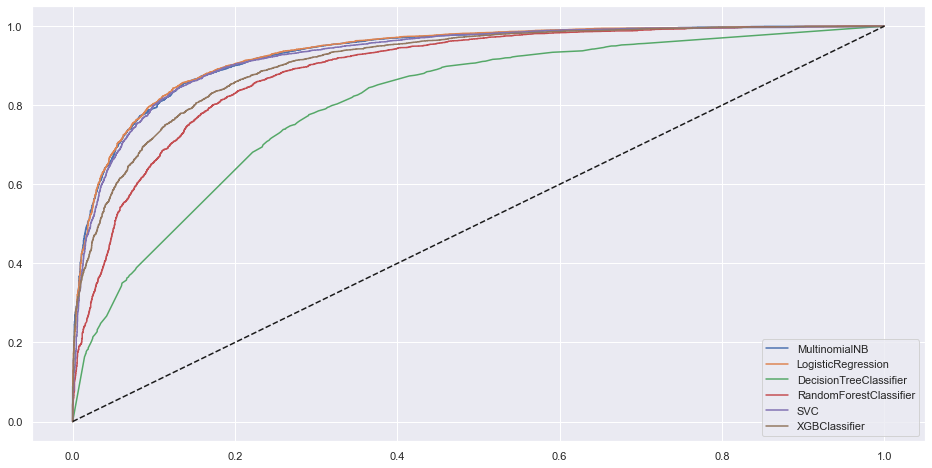

In [94]:
# comparing roc auc curves of models

pred_probs = [roc_curve(y_test, model.predict_proba(X_test)[:,1]) for model in best_models]
plt.figure(figsize=(16,8))
for i, model in enumerate(pred_probs):
    plt.plot(model[0], model[1], label=model_names[i])
plt.plot([0,1], [0,1], 'k--')
plt.legend();

We can see that Linear Regression achieves best results across all metrics with exception of precision, where NB Classifier gets better of it. SVC performs almost as well, but due to computational complexity and size of data it works much slower and is less convinient to use. Tree algorithms clearly underperform.

## Conclusions

Concluding, the best model we found for our task of recognizing sarcasm in news headlines is Logistic Regression with l2 type of regularization, C parameter equal 5 and "Saga" solver. It classifies headlines in test set correctly 86 out of 100 times, which is definitly better than random guessing. It is difficult to say how this compares with human score, because that may vary a lot. Lets take an example of actual headline from Huffington Post, that a person not knowing about recent scandal in chess world, most probably would take as a joke:

In [98]:
real_headline = ["Chess Grandmaster Accused Of Cheating Has Butt Scanned Before Game"]

log_reg.predict(real_headline), log_reg.predict_proba(real_headline)

(array([0], dtype=int64), array([[0.7659024, 0.2340976]]))

Our model is pretty sure that this is not a sarcastic headline!

For traing we used dataset of headlines from couple years ago, so topics and vocabulary definitly have changed and probably so has accuracy of our model. It is worth checking to what extend it was able to generalize detecting sarcasm and how much worse result it gets on headlines from different time period.

In [101]:
# loading fresh headlines
fresh_headlines = pd.read_csv('fresh_headlines.csv', index_col=0)
X, y = fresh_headlines['headline'], fresh_headlines['is_sarcastic']
X = X.map(cleaner)
X

0       most glaring times trump s children have broke...
1       anna faris names director she says touched her...
2       guy in line for port a potty won t stop assuri...
3       embattled gop candidate j r majewski also exag...
4       rep lofgren teases pretty surprising material ...
                              ...                        
1030    watch a honey badger fight 3 leopards in unbel...
1031    biden secures liberal priorities with little r...
1032    pilot sues southwest after colleague exposed h...
1033    annoying boyfriend always leaves toilet seat r...
1034    chess grandmaster accused of cheating has butt...
Name: headline, Length: 1035, dtype: object

In [102]:
accuracy_score(y, log_reg.predict(X))

0.7043478260869566

Clearly worse than before, but still 7 out of 10 times model is right!

## Final remarks

- There is still a lot of room for experimenting with text representation and feature engineering
- Tuning parameters of models could be more thorough but due to high dimentionality of data after vectorization it cost too much time.
- An answer to that could be dimentionality reduction with techniques like SVD or PCA, but some rough testing showed that models were getting worse results
- There are some other types of models that could be worth trying out, including deep learning methods

Finally, it is worth noting that "detecting sarcasm" in this project is a little bit of overstatement. We tought algorythm to differentiate headlines from two websites based on used vocabulary. To recognize sarcasm, much more powerful generalization capability is required, and I'm not sure if such algorythms yet exist. And even humans not always can do that, after all The Onion is notorious for being mistaken for real news. :)